In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/regomix-data1/Lunar_clean_try.xlsx


In [2]:
#BELOW IS THE CODE FOR KNN IMPUTATION.
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

def clean_impute_and_scale(df_subset, region_label):
    min_non_na_columns = int(df_subset.shape[0] * 0.4)
    cols_to_keep = df_subset.columns[df_subset.isnull().sum() <= (df_subset.shape[0] - min_non_na_columns)]
    cols_dropped = df_subset.columns.difference(cols_to_keep)

    numeric_cols = df_subset[cols_to_keep].select_dtypes(include=['float64', 'int64']).columns
    numeric_data = df_subset[numeric_cols]

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(numeric_data)

    imputer = KNNImputer(n_neighbors=4)
    imputed_scaled = imputer.fit_transform(scaled_data)

    imputed_original = scaler.inverse_transform(imputed_scaled)

    df_imputed_numeric = pd.DataFrame(imputed_original, columns=numeric_cols, index=numeric_data.index)

    df_final = df_subset.copy()

    df_final.loc[df_imputed_numeric.index, numeric_cols] = df_imputed_numeric

    for col in cols_dropped:
        df_final[col] = df_subset[col]

    df_final['Region'] = region_label

    return df_final
#IMPORT ORIGINAL DATSET FOR MINERAL COMPOSITON FROM REGOMIX DATASET FOLDER IN DRIVE
df1 = pd.read_excel('/kaggle/input/regomix-data1/Lunar_clean_try.xlsx', engine='openpyxl')
df = df1.copy()

df_mare = df[(df['mare'].str.contains('Mare', case=False, na=False)) & (df['LS/ES'] == 'LS')]
df_highland = df[(df['mare'].str.contains('Highland', case=False, na=False)) & (df['LS/ES'] == 'LS')]
df_earth = df[df['LS/ES'] == 'ES']

imputed_mare = clean_impute_and_scale(df_mare, 'Mare')
imputed_highland = clean_impute_and_scale(df_highland, 'Highland')
imputed_earth = clean_impute_and_scale(df_earth, 'Earth')

combined_df = pd.concat([imputed_mare, imputed_highland, imputed_earth], sort=False)
#OUTPUT SAVED AS CLEANED DATASET IN REGOMIX DATSET FOLDER IN DRIVE
combined_df.to_excel('combined_imputed_data_original_format.xlsx', index=False)


In [3]:
#BELOW IS THE CODE FOR EVALUATING THE ACCURACY FOR KNN IMPUTATION
def evaluate_knn_imputation(df_subset, region_label, missing_frac=0.1, random_state=42):
    numeric_cols = df_subset.select_dtypes(include=['float64', 'int64']).columns
    numeric_data = df_subset[numeric_cols]

    # Only mask positions that are currently NOT NaN
    non_na_mask = ~numeric_data.isnull()
    valid_data = numeric_data.copy()

    np.random.seed(random_state)
    random_mask = (np.random.rand(*numeric_data.shape) < missing_frac) & non_na_mask
    masked_data = valid_data.mask(random_mask)

    # Scale
    scaler = MinMaxScaler()
    scaled_masked = scaler.fit_transform(masked_data)
    
    # KNN Impute
    imputer = KNNImputer(n_neighbors=4)
    imputed_scaled = imputer.fit_transform(scaled_masked)
    imputed_data = scaler.inverse_transform(imputed_scaled)

    # Evaluation
    original = numeric_data.to_numpy()[random_mask.to_numpy()]
    predicted = imputed_data[random_mask.to_numpy()]

    mse = mean_squared_error(original, predicted)
    r2 = r2_score(original, predicted)

    print(f"[{region_label}] MSE: {mse:.4f}, R²: {r2:.4f}")
    return mse, r2

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


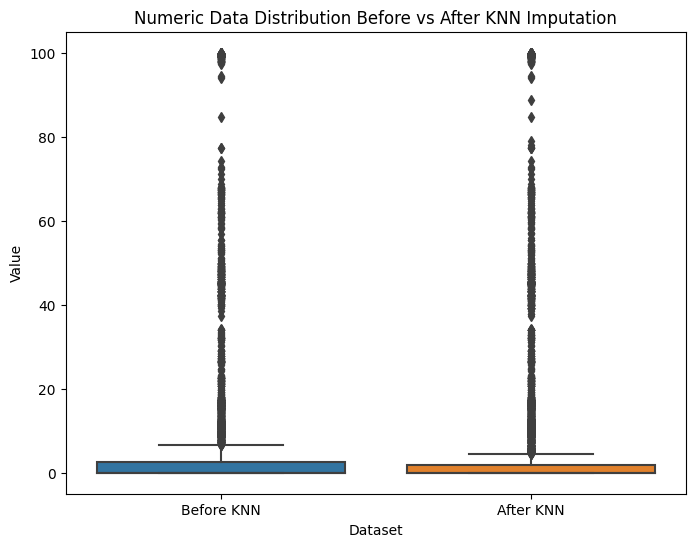

In [5]:
#BELOW IS THE CODE FOR VISUALIZING KNN IMPUTATION USING BOX AND PLOT DIAGRAM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Collect numeric data before and after imputation
numeric_before = df.select_dtypes(include=['float64', 'int64']).values.flatten()
numeric_after = combined_df.select_dtypes(include=['float64', 'int64']).values.flatten()

# Drop NaN values from before (since after imputation has no NaN)
numeric_before = numeric_before[~np.isnan(numeric_before)]

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    "Value": np.concatenate([numeric_before, numeric_after]),
    "Dataset": ["Before KNN"] * len(numeric_before) + ["After KNN"] * len(numeric_after)
})

# --- Remove outliers above 99th percentile ---
upper_limit = plot_df["Value"].quantile(0.99)
plot_df = plot_df[plot_df["Value"] <= upper_limit]

# Single boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="Dataset", y="Value", data=plot_df)
plt.title("Numeric Data Distribution Before vs After KNN Imputation")
plt.show()